# Исследование влияния различных внешних факторов на спрос на велосипеды

Здесь пока ничего интересного, просто импортируем необходимые библиотеки

In [37]:
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
import statsmodels.api as sm

In [5]:
def plot_yreal_ypred(y_train, y_train_hat):
    """
        Рисует картинку для прогнозов регрессии
    """

    margin = 0.1 # отступ на границах
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.scatter(y_train, y_train_hat, color="red", alpha=0.5)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.axis('equal')
    plt.axis('square')
    train_min = min(y_train)
    train_max = max(y_train)
    plt.xlim(train_min - margin, train_max + margin)
    plt.ylim(train_min - margin, train_max + margin)
    plt.plot([-10000, 10000], [-10000, 10000])
    plt.title('Линейная регрессия', fontsize=15)

## Загрузка и описание данных

### Подгружаем данные

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/kharimych/IDZ/main/bikes_rent.csv')

In [7]:
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,10.486773,2114
727,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,4.656485,3095
728,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,3.725374,1341
729,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,10.505372,1796


In [8]:
var_cat = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

var_real = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']
target = 'cnt'

### Описываем переменные

* `season`  1 - весна, 2 - лето, 3 - осень, 4 - зима
* `yr`  0 - 2011, 1 - 2012
* `mnth`  от 1 до 12
* `holiday`  0 - нет праздника, 1 - есть праздник
* `weekday`  от 0 до 6
* `workingday`  0 - нерабочий день, 1 - рабочий день
* `weathersit`  оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* `temp`  температура в Цельсиях
* `atemp`  температура по ощущениям в Цельсиях
* `hum`  влажность
* `windspeed(mph)`  скорость ветра в милях в час
* `windspeed(ms)`  скорость ветра в метрах в секунду
* `cnt`  количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

## Обработка данных

Для начала посмотрим на корреляцию неперерывных признаков, чтобы освободить данные от линейно зависимых регрессоров

<Axes: >

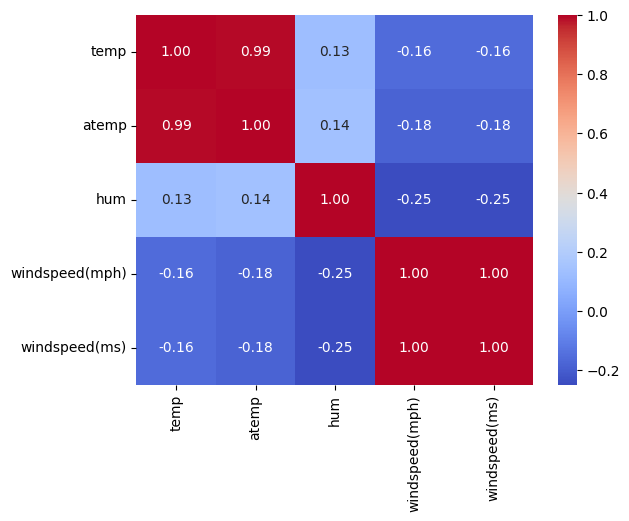

In [9]:
m = np.eye(5)
for i in range(m.shape[0]):
  m[i] = df[var_real].corrwith(df[var_real[i]])
corrm = pd.DataFrame(m)
corrm.columns = var_real
corrm.index = var_real
sns.heatmap(corrm, annot=True, cmap='coolwarm', fmt=".2f")

Как видно из корреляционной матрицы, признаки `atemp`, `temp` и `windspeed(mph)` `windspeed(ms)` имеют линейную зависимость. Удалим скорость ветра в милях, а также `atemp`

In [10]:
df = df.drop(['atemp', 'windspeed(mph)'], axis = 1)

In [11]:
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,80.5833,4.805490,985
1,1,0,1,0,0,0,2,14.902598,69.6087,7.443949,801
2,1,0,1,0,1,1,1,8.050924,43.7273,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,59.0435,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,43.6957,5.597810,1600
...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,10.420847,65.2917,10.486773,2114
727,1,1,12,0,5,1,2,10.386653,59.0000,4.656485,3095
728,1,1,12,0,6,0,2,10.386653,75.2917,3.725374,1341
729,1,1,12,0,0,0,1,10.489153,48.3333,10.505372,1796


Как уже было сказано раннее, переменные `season`, `yr`, `mnth`, `holiday`, `weekday`, `workingday`, `weathersit` - категориальные, поэтому, чтобы построить из них линейную регрессию, преобразуем их в dummy-переменные. Также избавимся от первой переменной, дабы избежать мультиколлинеарность

In [12]:
df[var_cat] = df[var_cat].applymap(lambda x: str(x))
df= pd.get_dummies(df, prefix = var_cat, dtype = int, drop_first = True )
df

/var/folders/6p/80ct6mvj5cv9c6fyfy3vdvfc0000gn/T/ipykernel_99291/2689270851.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[var_cat] = df[var_cat].applymap(lambda x: str(x))


,temp,hum,windspeed(ms),cnt,season_2,season_3,season_4,yr_1,mnth_10,mnth_11,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,14.110847,80.5833,4.805490,985,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,14.902598,69.6087,7.443949,801,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,8.050924,43.7273,7.437060,1349,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,8.200000,59.0435,4.800998,1562,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,9.305237,43.6957,5.597810,1600,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,10.420847,65.2917,10.486773,2114,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1,0
727,10.386653,59.0000,4.656485,3095,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,1,0
728,10.386653,75.2917,3.725374,1341,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
729,10.489153,48.3333,10.505372,1796,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Построение линейной регрессии

Для построения линейной регессии вида: $Y=X \beta + C + \mathcal{E}$, где $Y$ - вектор регрессант, $X$ - матрица регрессоров, а $\beta$ - вектор коэффициентов регрессии, $\mathcal{E}$ - матрица ошибок, С - вектор констант

Коэффициенты будем искать по формуле:

$\hat{\beta} = (X^TX)^{-1}X^TY$

Реализуем сразу все операции с помощью встроенных в питон функций (подключим sklearn)

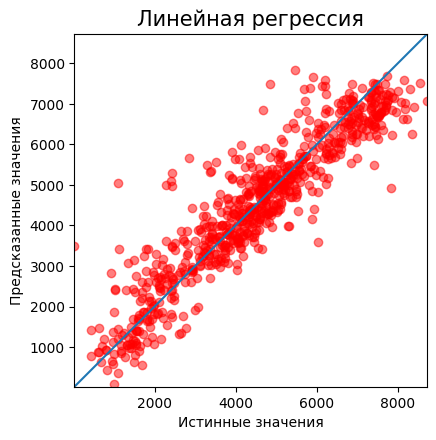

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(df.drop('cnt', axis = 1), df['cnt'])
y_pred = model.predict(df.drop('cnt', axis = 1))
plot_yreal_ypred(df['cnt'], y_pred)

Запросим коэффициенты регрессии

In [29]:
coefficients = model.coef_
coefficients

array([  109.44646105,   -15.1817754 ,   -97.67469173,   889.30153032,
         832.23555577,  1578.9465513 ,  2018.06292984,   520.93655065,
        -111.36215372,   -84.38933043,   136.85525335,   545.13192571,
         456.49444043,   723.52023258,   490.55246351,     8.40445935,
         404.91183149,   983.94813694,  -272.34347077,  -116.38492513,
         -22.12972874,    46.14575346,    53.94448383,    97.34266317,
         438.69869332,   331.26171737,  -465.20243408, -1981.35702037])

А также свободный член

In [30]:
intercept = model.intercept_
intercept

1543.551765387745

Посчитаем $R^2$

In [31]:
R2(df['cnt'], y_pred)

0.8480454828185913

## Проверка значимости

Проверку значимости будем осущетсвлять с помощью t-статистики: $\frac{\hat{\beta}}{SE(\hat{\beta_i})}$ и p-value

In [41]:
X_with_const = np.column_stack((np.ones(df.shape[0]), df.drop('cnt', axis = 1)))
residuals = df['cnt'] - y_pred
RSS = np.sum(residuals**2)
degrees_of_freedom = df.shape[0] - X_with_const.shape[1]
sigma_squared_hat = RSS / degrees_of_freedom
var_beta_hat = sigma_squared_hat * np.linalg.inv(X_with_const.T @ X_with_const)
SE_beta_hat = np.sqrt(np.diag(var_beta_hat))

#t-статистики для коэффициентов
t_stats = np.array([intercept] + list(coefficients))/SE_beta_hat

#p-значения для t-статистик
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=degrees_of_freedom))

print("\nРезультаты проверки значимости коэффициентов:")
for i in range(len(t_stats)):
    if i == 0:
        print(f'Свободный член: t-статистика = {t_stats[i]:.4f}, p-value = {p_values[i]:.4f}')
    else:
        print(f'Коэффициент {i}: t-статистика = {t_stats[i]:.4f}, p-value = {p_values[i]:.4f}')
alpha = 0.05

#Подтверждение/опровержение нулевой гипотезы о незначимости коэффициента
print("\nРезультаты проверки значимости коэффициентов:")
for i in range(len(t_stats)):
    if i == 0:
        variable_name = "Intercept"
    else:
        variable_name = f'Коэффициент {i}'
    print(f'{variable_name}: t-статистика = {t_stats[i]:.4f}, p-value = {p_values[i]:.4f}')
    if p_values[i] < alpha:
        print(f'  -> Нулевая гипотеза отклоняется. Коэффициент значим (p < {alpha}).')
    else:
        print(f'  -> Нулевая гипотеза принимается. Коэффициент не значим (p >= {alpha}).')


Результаты проверки значимости коэффициентов:
Свободный член: t-статистика = 6.5600, p-value = 0.0000
Коэффициент 1: t-статистика = 10.8881, p-value = 0.0000
Коэффициент 2: t-статистика = -5.1918, p-value = 0.0000
Коэффициент 3: t-статистика = -7.1973, p-value = 0.0000
Коэффициент 4: t-статистика = 4.9504, p-value = 0.0000
Коэффициент 5: t-статистика = 3.9007, p-value = 0.0001
Коэффициент 6: t-статистика = 8.7153, p-value = 0.0000
Коэффициент 7: t-статистика = 34.6353, p-value = 0.0000
Коэффициент 8: t-статистика = 2.1543, p-value = 0.0316
Коэффициент 9: t-статистика = -0.4821, p-value = 0.6299
Коэффициент 10: t-статистика = -0.4628, p-value = 0.6437
Коэффициент 11: t-статистика = 0.9514, p-value = 0.3417
Коэффициент 12: t-статистика = 3.2919, p-value = 0.0010
Коэффициент 13: t-статистика = 1.8423, p-value = 0.0659
Коэффициент 14: t-статистика = 2.7024, p-value = 0.0071
Коэффициент 15: t-статистика = 1.7397, p-value = 0.0824
Коэффициент 16: t-статистика = 0.0268, p-value = 0.9786
Коэф

/var/folders/6p/80ct6mvj5cv9c6fyfy3vdvfc0000gn/T/ipykernel_99291/531050540.py:7: RuntimeWarning: invalid value encountered in sqrt
  SE_beta_hat = np.sqrt(np.diag(var_beta_hat))


Как можно заметить, меньшая часть коэффициентов получились не значимыми, в то время как больше все еще осталась значимой